In [2]:
from pathlib import Path
from raster_manipulation import save_raster, clip_raster
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Ignore warnings from numpy (division by 0 or nan)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [32]:
#country_names = [f.name for f in Path("./").iterdir() if len(f.name)==3]
country_names = ['GMB']

for country in country_names:
    
    NTL_files = [file for file in Path("./"+country+"/NTL").iterdir()
                if "local-correction" not in file.name]
    
    misc_data_files = [file.name for file in Path("./"+country+"/misc_data").iterdir()]
    
    # Opening area of interest (AOI)
    
    aoi_name = "gadm36_"+country+".gpkg"
    aoi_in = Path("./"+country+"/misc_data") / aoi_name
    aoi = gpd.read_file(aoi_in, layer='gadm36_'+country+'_0')
    
    for NTL_file in NTL_files:
        
        # Opening the population raster to identify unhabited areas
        
        if "HRSL_"+country+"_NTL-resolution.tif" in misc_data_files:
            raster_pop_name = 'HRSL_'+country+'_NTL-resolution.tif'
            raster_pop_in = Path("./"+country+"/misc_data") / raster_pop_name
            raster_pop = rasterio.open(raster_pop_in).read(1)
        else:
            population_threshold = 20 # Population threshold for WorldPop rasters to distinguish inhabited/uninhabited areas
            year = NTL_file.name[4:8]
            raster_pop_name = 'worldpop_'+year+'_'+country+'_NTL-resolution.tif' # WorldPop data from the exact same year is not necessary
            raster_pop_in = Path("./"+country+"/worldpop") / raster_pop_name
            raster_pop = rasterio.open(raster_pop_in).read(1)
            raster_pop = (raster_pop>20)*raster_pop
            
        # Opening NTL raster
        
        ntl = rasterio.open(NTL_files[0])
        ntl_rd = ntl.read(1)
        
        # Replacing 0 values, i.e where no data is available, by np.nan
        
        ntl_nodata = 1.0*(rasterio.open(NTL_files[0]).read_masks()==255)[0]
        ntl_nodata[ntl_nodata == 0.] = np.nan
        
        # Creating 2 masks, one for populated areas and another for unpopulated areas
        
        mask_ntl_pop = np.full_like(ntl_rd, np.nan)
        mask_ntl_pop[raster_pop>0] = 1
        mask_ntl_unpop = np.full_like(ntl_rd, np.nan)
        mask_ntl_unpop[raster_pop<=0] = 1
        mask_ntl_unpop[np.isnan(raster_pop)] = 1
        mask_ntl_unpop = mask_ntl_unpop*ntl_nodata

        ntl_rd_pop = ntl_rd*mask_ntl_pop
        ntl_rd_unpop = ntl_rd*mask_ntl_unpop
        ntl_corr = np.full_like(ntl_rd, np.nan)
        
        # Beginning the correction process
        
        # Each NTL value is corrected based on the following principle:
        # Look for unpopulated cells in the surroundings of the cell to be corrected
        # Surroundings is determined by a (2 x diameter) x 2 x diameter) square around the cell to be corrected
        # >250 unpopulated cells should be found in the surroundings, otherwise, diameter increases until >250 unpopulated cells are found
        # The lowest and highest deciles of the >250 NTL values are removed
        # Withdraw of the mean value of radiance of the remaining unpopulated cells from the cell being corrected
        # 
        # In short terms, NTL values are corrected by withdrawing the average value of radiance of unpopulated cells closeby
        # Unpopulated cells are corrected by considering they should be dark (radiance is naught).
        
        diameter = 15

        for row in range(ntl_corr.shape[0]):
            for col in range(ntl_corr.shape[1]):
                if ntl_nodata[row, col] == 1:
                    diameter_temp = diameter
                    unpop_surroundings = ntl_rd_unpop[max(0,row-diameter_temp):min(ntl_rd_pop.shape[0],row+diameter_temp+1), max(0,col-diameter_temp):min(ntl_rd_pop.shape[1],col+diameter_temp+1)]
                    while np.count_nonzero(~np.isnan(unpop_surroundings))<250:
                        diameter_temp += 1
                        unpop_surroundings = ntl_rd_unpop[max(0,row-diameter_temp):min(ntl_rd_pop.shape[0],row+diameter_temp+1), max(0,col-diameter_temp):min(ntl_rd_pop.shape[1],col+diameter_temp+1)]

                    list_unpop_surroundings = unpop_surroundings[np.logical_not(np.isnan(unpop_surroundings))]
                    list_unpop_surroundings.sort()
                    list_unpop_surroundings = list_unpop_surroundings[int(len(list_unpop_surroundings)/10):-int(len(list_unpop_surroundings)/10)]
                    ntl_corr[row,col] = ntl_rd[row,col]-list_unpop_surroundings.mean()

            if row/100 == np.floor(row/100):
                print(NTL_file.stem, int(row/ntl_rd_pop.shape[0]*100),'%      ',end="\r")
        
        # If radiance is found negative, radiance is set to 0
        
        ntl_corr[ntl_corr<0] = 0
        
        # Radiance of unpopulated cells is set to 0
        
        ntl_corr[raster_pop<=0] = 0

        print(NTL_file.stem, '100 %      ',end="\r")
        
        # Saving corrected raster
        
        ntl_out = NTL_file.stem+'_local-correction'+NTL_file.suffix
        path_out = Path("./"+country+"/NTL") / ntl_out
        save_raster(path_out, ntl_corr, ntl.transform)
        clipped, aff, crs = clip_raster(path_out, aoi)
        save_raster(path_out, clipped, aff)

# Observing correction

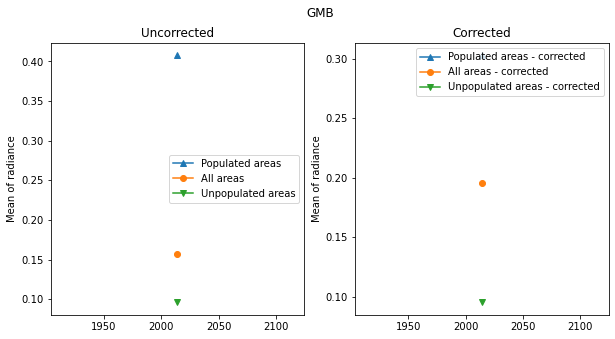

In [49]:
#country_names = [f.name for f in Path("./").iterdir() if len(f.name)==3]
country_names = ['GMB']

for country in country_names:

    NTL_files = [file for file in Path("./"+country+"/NTL").iterdir()
            if "local-correction" in file.name]
    
    years = []
    for NTL_file in NTL_files:
        years.append(NTL_file.name[4:8])
    years.sort()

    results_all = []
    results_unpop = []
    results_pop = []
    
    results_all_corr = []
    results_unpop_corr = []
    results_pop_corr = []
    
    for year in years:
    
        # Opening the population raster to identify unhabited areas

        if "HRSL_"+country+"_NTL-resolution.tif" in misc_data_files:
            raster_pop_name = 'HRSL_'+country+'_NTL-resolution.tif'
            raster_pop_in = Path("./"+country+"/misc_data") / raster_pop_name
            raster_pop = rasterio.open(raster_pop_in).read(1)
        else:
            population_threshold = 20 # Population threshold for WorldPop rasters to distinguish inhabited/uninhabited areas
            raster_pop_name = 'worldpop_'+year+'_'+country+'_NTL-resolution.tif' # WorldPop data from the exact same year is not necessary
            raster_pop_in = Path("./"+country+"/worldpop") / raster_pop_name
            raster_pop = rasterio.open(raster_pop_in).read(1)
            raster_pop = (raster_pop>20)*raster_pop

        # Opening NTL rasters
        
        ntl_name = "NTL_"+year+"_"+country+".tif"
        ntl_in = Path("./"+country+'/NTL') / ntl_name
        ntl = rasterio.open(ntl_in)
        ntl_rd = ntl.read(1)
        
        ntl_corr_name = "NTL_"+year+"_"+country+"_local-correction.tif"
        ntl_corr_in = Path("./"+country+'/NTL') / ntl_corr_name
        ntl_corr = rasterio.open(ntl_corr_in)
        ntl_corr_rd = ntl_corr.read(1)

        # Replacing 0 values, i.e where no data is available, by np.nan

        ntl_nodata = 1.0*(rasterio.open(ntl_in).read_masks()==255)[0]
        ntl_nodata[ntl_nodata == 0.] = np.nan
        
        ntl_corr_nodata = 1.0*(rasterio.open(ntl_corr_in).read_masks()==255)[0]
        ntl_corr_nodata[ntl_corr_nodata == 0.] = np.nan

        # Creating 2 masks, one for populated areas and another for unpopulated areas

        mask_ntl_pop = np.full_like(ntl_rd, np.nan)
        mask_ntl_pop[raster_pop>0] = 1
        mask_ntl_unpop = np.full_like(ntl_rd, np.nan)
        mask_ntl_unpop[raster_pop<=0] = 1
        mask_ntl_unpop[np.isnan(raster_pop)] = 1
        mask_ntl_unpop = mask_ntl_unpop*ntl_nodata

        ntl_rd_pop = ntl_rd*mask_ntl_pop
        ntl_rd_unpop = ntl_rd*mask_ntl_unpop
        ntl_rd = ntl_rd*ntl_nodata
    
        results_all.append(np.nanmean(ntl_rd))
        results_unpop.append(np.nanmean(ntl_rd_unpop))
        results_pop.append(np.nanmean(ntl_rd_pop))
        
        mask_ntl_corr_pop = np.full_like(ntl_corr_rd, np.nan)
        mask_ntl_corr_pop[raster_pop>0] = 1
        mask_ntl_corr_unpop = np.full_like(ntl_corr_rd, np.nan)
        mask_ntl_corr_unpop[raster_pop<=0] = 1
        mask_ntl_corr_unpop[np.isnan(raster_pop)] = 1
        mask_ntl_corr_unpop = mask_ntl_corr_unpop*ntl_corr_nodata

        ntl_corr_rd_pop = ntl_corr_rd*mask_ntl_corr_pop
        ntl_corr_rd_unpop = ntl_corr_rd*mask_ntl_corr_unpop
        ntl_corr_rd = ntl_corr_rd*ntl_corr_nodata
    
        results_all_corr.append(np.nanmean(ntl_corr_rd))
        results_unpop_corr.append(np.nanmean(ntl_corr_rd_unpop))
        results_pop_corr.append(np.nanmean(ntl_corr_rd_pop))

    plt.figure(figsize=(10,5))
    plt.suptitle(country)
    plt.subplot(121)
    plt.title('Uncorrected')
    plt.plot([int(year) for year in years], results_pop, '^-')
    plt.plot([int(year) for year in years], results_all, 'o-')
    plt.plot([int(year) for year in years], results_unpop, 'v-')
    plt.legend(['Populated areas','All areas','Unpopulated areas'])
    plt.ylabel('Mean of radiance')

    plt.subplot(122)
    plt.title('Corrected')
    plt.plot([int(year) for year in years], results_pop_corr, '^-')
    plt.plot([int(year) for year in years], results_all_corr, 'o-')
    plt.plot([int(year) for year in years], results_unpop_corr, 'v-')
    plt.legend(['Populated areas - corrected','All areas - corrected','Unpopulated areas - corrected'])
    plt.ylabel('Mean of radiance')
    
    plt.show()